# Studying Statistical Distance Across Layers and θ Variations

### Overview
This notebook analyzes how the number of Galton box layers and the coin flip angle θ affect the similarity between ideal and noisy outputs. The key metric used is the Total Variation Distance (TVD).

### Goals
- Simulate Galton boards for various layer counts and θ values.
- Calculate TVD for each configuration.
- Visualize the relationship between circuit complexity and accuracy.

[•] Layers=2, KL=0.0003
[•] Layers=3, KL=0.0006
[•] Layers=4, KL=0.0027
[•] Layers=5, KL=0.0067
[•] Layers=6, KL=0.0111


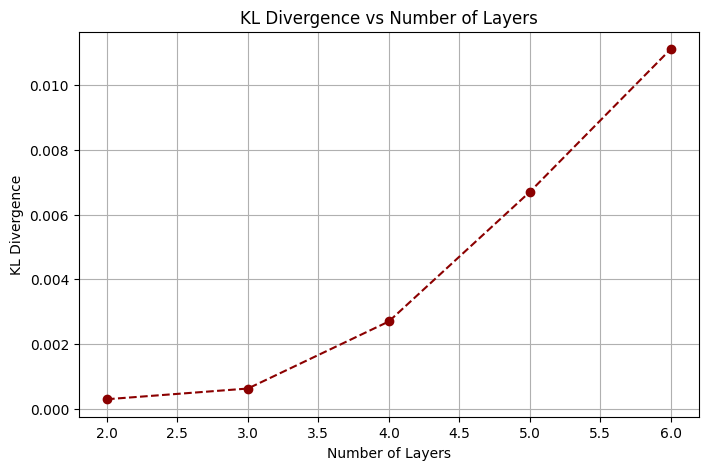

[✓] Plot saved to: ../outputs/Derivable4d/kl_vs_layers.png
[•] L=2, θ=0.10 → KL=0.0032
[•] L=2, θ=0.31 → KL=0.0007
[•] L=2, θ=0.52 → KL=0.0007
[•] L=2, θ=0.73 → KL=0.0005
[•] L=2, θ=0.94 → KL=0.0001
[•] L=2, θ=1.15 → KL=0.0002
[•] L=2, θ=1.36 → KL=0.0002
[•] L=2, θ=1.57 → KL=0.0008
[•] L=3, θ=0.10 → KL=0.0061
[•] L=3, θ=0.31 → KL=0.0022
[•] L=3, θ=0.52 → KL=0.0017
[•] L=3, θ=0.73 → KL=0.0005
[•] L=3, θ=0.94 → KL=0.0003
[•] L=3, θ=1.15 → KL=0.0013
[•] L=3, θ=1.36 → KL=0.0005
[•] L=3, θ=1.57 → KL=0.0013
[•] L=4, θ=0.10 → KL=0.0087
[•] L=4, θ=0.31 → KL=0.0029
[•] L=4, θ=0.52 → KL=0.0084
[•] L=4, θ=0.73 → KL=0.0010
[•] L=4, θ=0.94 → KL=0.0014
[•] L=4, θ=1.15 → KL=0.0024
[•] L=4, θ=1.36 → KL=0.0018
[•] L=4, θ=1.57 → KL=0.0015
[•] L=5, θ=0.10 → KL=0.0139
[•] L=5, θ=0.31 → KL=0.0050
[•] L=5, θ=0.52 → KL=0.0043
[•] L=5, θ=0.73 → KL=0.0024
[•] L=5, θ=0.94 → KL=0.0043
[•] L=5, θ=1.15 → KL=0.0026
[•] L=5, θ=1.36 → KL=0.0056
[•] L=5, θ=1.57 → KL=0.0047
[•] L=6, θ=0.10 → KL=0.0191
[•] L=6, θ=0.31 →

<Figure size 640x480 with 0 Axes>

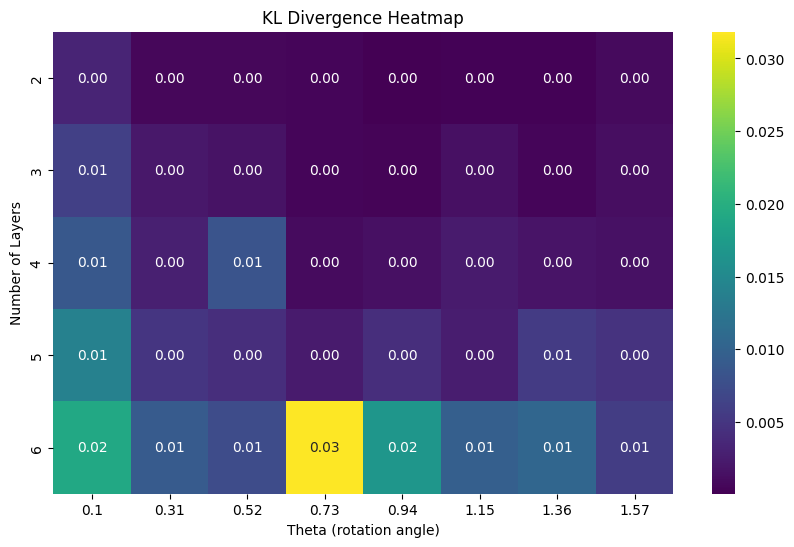

In [2]:
#Statistical Distance vs Number of Layers and Theta
# --------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

import os
# Create output directory
output_dir = "../outputs/Derivable4d/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist

# ----------------------------------------------------------
# Quantum walk circuit with biased rotation
# ----------------------------------------------------------
def build_biased_quantum_walk(n_layers, theta):
    qr = QuantumRegister(n_layers)
    cr = ClassicalRegister(n_layers)
    qc = QuantumCircuit(qr, cr)

    for i in range(n_layers):
        qc.ry(theta, qr[i])

    qc.barrier()
    qc.measure(qr, cr)
    return qc

# ----------------------------------------------------------
# Noise model (same as Task 4c)
# ----------------------------------------------------------
def create_basic_noise_model():
    noise_model = NoiseModel()
    dep_error = depolarizing_error(0.01, 1)
    t1, t2, gate_time = 100e3, 80e3, 50
    thermal_error = thermal_relaxation_error(t1, t2, gate_time)

    noise_model.add_all_qubit_quantum_error(dep_error, ['ry'])
    noise_model.add_all_qubit_quantum_error(thermal_error, ['measure'])
    return noise_model

# ----------------------------------------------------------
# Simulate and convert counts to probs
# ----------------------------------------------------------
def simulate_distribution(n_layers, theta, shots=8192, noisy=False):
    qc = build_biased_quantum_walk(n_layers, theta)
    simulator = AerSimulator(noise_model=create_basic_noise_model()) if noisy else AerSimulator()
    transpiled = transpile(qc, simulator)
    result = simulator.run(transpiled, shots=shots).result()
    counts = result.get_counts()
    
    total = sum(counts.values())
    probs = np.zeros(2**n_layers)
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        probs[index] = count / total
    return probs

# ----------------------------------------------------------
# KL Divergence
# ----------------------------------------------------------
def kl_divergence(p, q, eps=1e-10):
    p += eps
    q += eps
    return entropy(p, q)

# ----------------------------------------------------------
# Plot 1: KL divergence vs Number of Layers
# ----------------------------------------------------------
def plot_kl_vs_layers(theta=np.pi/4, max_layers=7, save_path=None):
    layers = list(range(2, max_layers+1))
    kl_values = []

    for n in layers:
        ideal = simulate_distribution(n, theta, noisy=False)
        noisy = simulate_distribution(n, theta, noisy=True)
        kl = kl_divergence(ideal, noisy)
        kl_values.append(kl)
        print(f"[•] Layers={n}, KL={kl:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(layers, kl_values, marker='o', linestyle='--', color='darkred')
    plt.title("KL Divergence vs Number of Layers")
    plt.xlabel("Number of Layers")
    plt.ylabel("KL Divergence")
    plt.grid(True)
    # save_path = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/kl_vs_layers.png"
    # plt.savefig(save_path)
    # print(f"[✓] Saved: {save_path}")
    # plt.show()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# ----------------------------------------------------------
# Plot 2: Heatmap of KL Divergence vs (layers, theta)
# ----------------------------------------------------------
def plot_kl_heatmap(layer_range=(2, 6), theta_range=(0.1, np.pi/2), theta_steps=10, save_path=None):
    layers = list(range(layer_range[0], layer_range[1] + 1))
    thetas = np.linspace(theta_range[0], theta_range[1], theta_steps)
    heatmap = np.zeros((len(layers), len(thetas)))

    for i, n in enumerate(layers):
        for j, theta in enumerate(thetas):
            ideal = simulate_distribution(n, theta, noisy=False)
            noisy = simulate_distribution(n, theta, noisy=True)
            kl = kl_divergence(ideal, noisy)
            heatmap[i, j] = kl
            print(f"[•] L={n}, θ={theta:.2f} → KL={kl:.4f}")

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap, xticklabels=np.round(thetas, 2), yticklabels=layers, cmap="viridis", annot=True, fmt=".2f")
    plt.xlabel("Theta (rotation angle)")
    plt.ylabel("Number of Layers")
    plt.title("KL Divergence Heatmap")
    # save_path_1 = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/kl_heatmap_layers_theta.png"
    # plt.savefig(save_path_1)
    # print(f"[✓] Saved: {save_path_1}")
    # plt.show()
    if save_path:
        plt.savefig(save_path, dpi=300)

# ----------------------------------------------------------
# Run and Display
# ----------------------------------------------------------
if __name__ == "__main__":
    plot_kl_vs_layers(theta=np.pi/4, max_layers=6)
    plot1_path=os.path.join(output_dir, "kl_vs_layers.png")
    plt.savefig(plot1_path, dpi=300)
    print(f"[✓] Plot saved to: {plot1_path}")
    
    plot_kl_heatmap(layer_range=(2, 6), theta_range=(0.1, np.pi/2), theta_steps=8)
    plot2_heatmap_path=os.path.join(output_dir, "kl_heatmap_layers_theta.png")
    plt.savefig(plot2_heatmap_path, dpi=300)